# 3. Applications illustratives de régression

Dans ce notebook, nous appliquerons les concepts introduits dans les tutoriels d'introduction 1 et 2 à des problèmes de régression simple univarié. Deux exemples sont explorés:
- Estimation des incertitudes résiduelle et épistémique d'une fonction uni-dimensionnelle $x \times sin(x)$ avec bruit homoscédastique
- Estimation des incertitudes d'une fonction polynomiale avec bruit hétéroscédastique dont l'écart type augmente linéairement avec $x$ pour différentes tailles du jeu de données

## Importation des librairies

In [48]:
import numpy as np
from numpy import random as npr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# limit the GPU memory growth to allow several trainings with tensorflow:
# https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Fonctions utiles

Commençons par définir quelques fonctions utiles pour générer et visualiser nos données.

## Génération des données

In [4]:
def gauss_function(x, a, mu, sig):
    """One-dimensional gaussian function."""
    return a*np.exp(-(x-mu)**2/(2*sig**2))

In [5]:
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)

In [6]:
def generate_onedimensional_data(
    funct,
    distrib='normal',
    noise=True,
    n_samples=100,
    mu=0,
    sig=1,
    sigfactor=1,
    min_x=-5,
    max_x=5,
    sig_noise=1
):
    """
    Generate one-dimensional data with homo- or hetero-scedastic noise
    from an input function and some information on the noise.
    """
    np.random.seed(59)
    if distrib == 'normal':
        X_train = npr.normal(mu, sig, n_samples)
        X_test = np.arange(mu-sigfactor*sig, mu+sigfactor*sig, sig/20.)
    elif distrib == 'uniform':
        X_train = np.linspace(min_x, max_x, n_samples)
        X_test = np.linspace(min_x, max_x, n_samples*5)
    y_train = funct(X_train)
    y_mesh = funct(X_test)
    y_test = funct(X_test)
    n_test = y_test.shape[0]
    if noise:
        n_samples = len(X_train)
        if isinstance(sig_noise, (int, float)):
            y_noise_train = npr.normal(0, sig_noise, n_samples)
            y_noise_test = npr.normal(0, sig_noise, n_test)
        elif isinstance(sig_noise, (list)):
            sig_noise_train = gauss_function(X_train, sig_noise[0], sig_noise[1], sig_noise[2])
            sig_noise_test = gauss_function(X_test, sig_noise[0], sig_noise[1], sig_noise[2])
            y_noise_train = np.array([npr.normal(0, noise, 1)[0] for noise in sig_noise_train])
            y_noise_test = np.array([npr.normal(0, noise, 1)[0] for noise in sig_noise_test])
        y_train += y_noise_train
        y_test += y_noise_test
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh


## Visualisation des données

In [7]:
def plot_1d_data(
    X_train,
    y_train,
    X_test,
    y_test,
    y_sigma,
    y_pred = None,
    y_pred_low = None,
    y_pred_up = None,
    ax: plt.Axes = None,
    title=None,
    alpha: float = 0.3
):
    """
    Compare predicted and true values for one-dimensional data.
    """
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.scatter(X_train, y_train, color="red", alpha=alpha, label="Training data")
    ax.plot(X_test, y_test, color="gray", label="True confidence intervals")
    if y_sigma is not None:
        ax.plot(X_test, y_test-y_sigma, color="gray", ls="--")
        ax.plot(X_test, y_test+y_sigma, color="gray", ls="--")
    if y_pred is not None:
        ax.plot(X_test, y_pred, color="blue", alpha=0.5, label="Prediction intervals")
        ax.fill_between(X_test, y_pred_low, y_pred_up, alpha=0.3)
    if title is not None:
        ax.set_title(title)
    ax.legend()

# 1. Fonction $x \times sin(x)$ avec bruit homoscédastique

$$ y_i = x_i \times \sin(x_i) + \epsilon_i$$
avec $\epsilon_i \sim N(0, \sigma)$ 
et $\sigma = 0.2$

## Génération des données homoscedastiques

In [8]:
sig_noise = [0.2, 0, 1e9]
X_train, y_train, X_test, y_test, y_mesh = generate_onedimensional_data(
    x_sinx,
    distrib='uniform',
    noise=True,
    n_samples=300,
    mu=0,
    sig=1,
    sigfactor=1,
    sig_noise=sig_noise
)

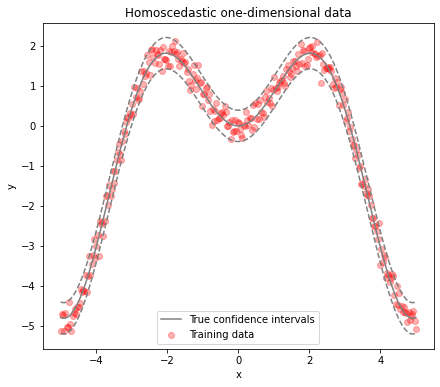

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(7, 6))
plot_1d_data(
    X_train.ravel(),
    y_train.ravel(), 
    X_test.ravel(),
    y_mesh.ravel(),
    1.96*sig_noise[0], 
    None,
    None,
    None,
    ax=axs,
    title="Homoscedastic one-dimensional data"
)

## Définition des modèles

Commençons par créer une fonction nous permettant de définir une architecture de MLP à couches denses déterministe ou probabiliste:
- `hidden_type` = "dense" ou "variationaldense" est le type de couches internes, toutes les couches internes seront du même type
- `output_type` = "deterministic" ou "probabilistic" est le type de la couche externe
- `hidden_units = List[int]` définit le nombre de neurones dans chaque couche interne
- `activations = List[str]` définit les fonctions d'activation de chaque interne
- `mcdropout` définit le taux de dropout après chaque couche interne, si 0 pas de couches de dropout 
- `prior` la fonction définissant le prior (si `hidden_type = "variationaldense"`)
- `posterior` la fonction définissant le posterior variationnel (si `hidden_type = "variationaldense"`)
- `loss` définit la loss, doit être la fonction de type `negative_log_likelihood` si `output_type = "probabilistic"`
- `optimizer` doit être un optimizer compatible avec Keras

In [10]:
def get_probabilistic_mlp(
    shape,
    hidden_type= "dense",
    output_type = "deterministic",
    hidden_units = [1],
    activations = ["relu"],
    mcdropout = 0.,
    prior = None,
    posterior = None,
    loss = "mean_squared_error",
    optimizer = "adam",
    verbose = 1
) -> Model:
    """
    Define a probabilistic MultiLayer Perceptron architecture from specified hidden
    units and activation functions, type of hidden and output layers, and functions
    for prior and posterior distributions, and compile the network.
    """
    inputs = Input(shape=(shape[1],))
    x = inputs
    for i, units in enumerate(hidden_units):
        if hidden_type == "variationaldense":
            x = tfpl.DenseVariational(
                units=units,
                make_prior_fn=prior,
                make_posterior_fn=posterior,
                kl_weight=1/shape[0],
                activation=activations[i]
            )(x)
        else:
            x = Dense(units, activation=activations[i])(x)
            if mcdropout > 0:
                x = Dropout(mcdropout)(x, training=True)
    if output_type == "probabilistic":
        x = Dense(tfpl.IndependentNormal.params_size(event_shape=1))(x)
        outputs = tfpl.IndependentNormal(event_shape=1)(x)
    else:
        outputs = Dense(units=1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    if output_type == 'probabilistic':
        loss = negative_log_likelihood
    model.compile(loss=loss, optimizer=optimizer)
    return model

**Modèle déterministe**

In [11]:
mlp_determ = get_probabilistic_mlp(
    shape=X_train.shape, 
    hidden_type="dense", 
    output_type="deterministic", 
    hidden_units=[32, 32], 
    activations=["relu", "relu"], 
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=0.01)
)

**Modèle avec MC Dropout**

In [12]:
mlp_mcdropout = get_probabilistic_mlp(
    shape=X_train.shape, 
    hidden_type="dense", 
    output_type="deterministic", 
    mcdropout=0.05,
    hidden_units=[32, 32], 
    activations=["relu", "relu"],
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=0.01)
)


**Modèle avec sortie probabiliste pour estimer l'incertitude aléatoire**

In [13]:
def negative_log_likelihood(y_true, y_pred):
    """Negative log likelihood."""
    return -y_pred.log_prob(y_true)

In [14]:
mlp_aleatoric = get_probabilistic_mlp(
    shape=X_train.shape, 
    hidden_type="dense", 
    output_type="probabilistic", 
    hidden_units=[32, 32], 
    activations=["relu", "relu"],
    loss=negative_log_likelihood,
    optimizer=Adam(learning_rate=0.01)
)


**Modèle bayésien pour estimer l'incertitude épistémique**

In [15]:
def prior(kernel_size, bias_size, dtype = None):
    """
    Multivariate Normal Diagonal non-trainable prior (loc=0, scale=1).
    """
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(
                loc=tf.zeros(n), scale_diag=tf.ones(n)
            )
        )
    ])
    return prior_model

In [16]:
def random_gaussian_initializer(shape, dtype):
    """
    Random gaussian initializer as defined in
    https://stackoverflow.com/questions/66418959/not-able-to-get-reasonable-results-from-densevariational
    """
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)


In [17]:
def posterior_mean_field(kernel_size, bias_size, dtype = None):
    """
    Mean-field posterior.
    More information can be found here:
    https://bjlkeng.github.io/posts/variational-bayes-and-the-mean-field-approximation/
    https://en.wikipedia.org/wiki/Variational_Bayesian_methods#Mean_field_approximation
    """
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return Sequential([
        tfpl.VariableLayer(
            2*n,
            dtype=dtype,
            initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype),
            trainable=True
        ),
        tfpl.DistributionLambda(
            lambda t: tfd.Independent(tfd.Normal(
                loc=t[..., :n],
                scale=1e-5 + 0.001*tf.nn.softplus(c + t[..., n:])
            ), reinterpreted_batch_ndims=1)
        ),
    ])


In [18]:
def posterior_tril(kernel_size, bias_size, dtype = None):
    """
    Multivariate Normal TriL trainable posterior.
    """
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model


In [19]:
mlp_epistemic = get_probabilistic_mlp(
    shape=X_train.shape, 
    hidden_type="variationaldense", 
    output_type="deterministic", 
    hidden_units=[32, 32], 
    activations=["sigmoid", "sigmoid"],
    loss="mean_squared_error", # negative_log_likelihood, # 
    prior=prior,
    posterior=posterior_mean_field,
    optimizer=Adam(learning_rate=0.01)
)


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [20]:
mlp_epistemic.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_variational (DenseVari (None, 32)                128       
_________________________________________________________________
dense_variational_1 (DenseVa (None, 32)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


## Entraînement des modèles

In [21]:
%%time
early_stopping = EarlyStopping(monitor="val_loss", patience=50)
hist_determ = mlp_determ.fit(
    X_train.reshape(-1, 1), y_train, 
    epochs=1000, 
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.1,
    verbose=True
)
y_determ_pred = mlp_determ.predict(X_test)

Epoch 1/1000
9/9 [==============================] - 1s 46ms/step - loss: 3.1073 - val_loss: 29.6304
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 2.7204 - val_loss: 16.3244
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.8753 - val_loss: 15.8294
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.6405 - val_loss: 15.2139
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.2637 - val_loss: 11.3182
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.7616 - val_loss: 7.8429
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.4385 - val_loss: 7.0902
Epoch 8/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.2424 - val_loss: 2.4711
Epoch 9/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.2166 - val_loss: 3.8263
Epoch 10/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.2016 - val_loss: 2.1138
Epoch 11/1000

In [22]:
%%time
early_stopping = EarlyStopping(monitor="val_loss", patience=100)
hist_mcdropout = mlp_mcdropout.fit(
    X_train.reshape(-1, 1), y_train, 
    epochs=1000, 
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.1,
    verbose=True
)
n_preds = 30
y_preds = np.stack([mlp_mcdropout.predict(X_test) for _ in range(n_preds)])
y_mcdrop_mean = y_preds.mean(axis=0)
y_mcdrop_sd = y_preds.std(axis=0)

Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 3.3436 - val_loss: 14.1273
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 2.3311 - val_loss: 15.4434
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 2.0662 - val_loss: 10.0922
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.5303 - val_loss: 12.4096
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.0478 - val_loss: 3.3334
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.8595 - val_loss: 2.8713
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6984 - val_loss: 1.9481
Epoch 8/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6060 - val_loss: 3.3320
Epoch 9/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4134 - val_loss: 1.0113
Epoch 10/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.4304 - val_loss: 0.6966
Epoch 11/1000


In [23]:
%%time
early_stopping = EarlyStopping(monitor="val_loss", patience=100)
hist_aleatoric = mlp_aleatoric.fit(
    X_train, y_train, 
    epochs=1000, 
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.1,
    verbose=True
)
y_aleatoric = mlp_aleatoric(X_test)
y_aleatoric_sample = y_aleatoric.sample()
y_aleatoric_mean = y_aleatoric.mean()
y_aleatoric_sd = y_aleatoric.stddev()

Epoch 1/1000
9/9 [==============================] - 1s 22ms/step - loss: 18.3211 - val_loss: 4.0480
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.9261 - val_loss: 3.3816
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.8193 - val_loss: 5.2610
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.7001 - val_loss: 4.1920
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.6765 - val_loss: 3.6771
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.5822 - val_loss: 4.8917
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.5657 - val_loss: 3.8013
Epoch 8/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.5670 - val_loss: 4.0123
Epoch 9/1000
9/9 [==============================] - 0s 7ms/step - loss: 1.5864 - val_loss: 4.0760
Epoch 10/1000
9/9 [==============================] - 0s 6ms/step - loss: 1.5583 - val_loss: 3.9686
Epoch 11/1000
9/9

In [24]:
%%time
early_stopping = EarlyStopping(monitor="val_loss", patience=1000)
hist_epistemic = mlp_epistemic.fit(
    X_train, y_train, 
    epochs=1000, 
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.1,
    verbose=True
)
y_epistemic = np.stack([mlp_epistemic(X_test) for _ in range(n_preds)])
y_epistemic_mean = np.mean(y_epistemic, axis=0) 
y_epistemic_sd = np.std(y_epistemic, axis=0) 

Epoch 1/1000
9/9 [==============================] - 1s 46ms/step - loss: 36.5986 - val_loss: 51.3011
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 35.8731 - val_loss: 55.5805
Epoch 3/1000
9/9 [==============================] - 0s 8ms/step - loss: 35.3343 - val_loss: 61.1120
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 35.4144 - val_loss: 64.7794
Epoch 5/1000
9/9 [==============================] - 0s 8ms/step - loss: 34.4973 - val_loss: 59.6936
Epoch 6/1000
9/9 [==============================] - 0s 8ms/step - loss: 34.1062 - val_loss: 62.7153
Epoch 7/1000
9/9 [==============================] - 0s 8ms/step - loss: 34.0331 - val_loss: 60.7304
Epoch 8/1000
9/9 [==============================] - 0s 8ms/step - loss: 33.6429 - val_loss: 60.5759
Epoch 9/1000
9/9 [==============================] - 0s 8ms/step - loss: 33.2092 - val_loss: 60.3597
Epoch 10/1000
9/9 [==============================] - 0s 8ms/step - loss: 32.9204 - val_loss: 58.904

## Visualisation des résultats

**Evolution de la loss en fonction du nombre d'epochs**

In [25]:
def plot_loss_history(
    history,
    plot_val = False,
    title = None,
    y_scale = "linear",
    legend = None,
    ax = None
):
    """
    Plot loss as function of epochs.
    """
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    if isinstance(history, list):
        lss = ["-", "--", "-."]
        for i, hist in enumerate(history):
            ax.plot(hist.history["loss"], label=history[i], ls=lss[i], color=f"C0")
            if plot_val:
                ax.plot(hist.history["val_loss"], label="Validation Loss", color=f"C1", ls=lss[i])
    else:
        ax.plot(history.history["loss"], label="Loss")
        if plot_val:
            ax.plot(history.history["val_loss"], label="Validation Loss")
    if title is not None:
        ax.set_title(title)
    ax.set_yscale(y_scale)
    if legend is None:
        ax.legend()
    else:
        ax.legend(legend)


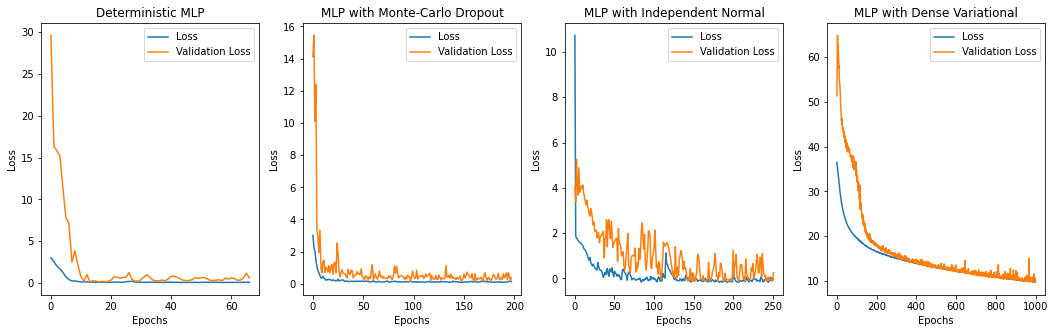

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharex=False, sharey=False)
titles = [
    'Deterministic MLP',
    'MLP with Monte-Carlo Dropout',
    'MLP with Independent Normal',
    'MLP with Dense Variational'
]
hists = [hist_determ, hist_mcdropout, hist_aleatoric, hist_epistemic]
for i, hist in enumerate(hists):
    plot_loss_history(hist, plot_val=True, title=titles[i], ax=axs[i])

**Visualisation des incertitudes estimées**

0
1
2
3


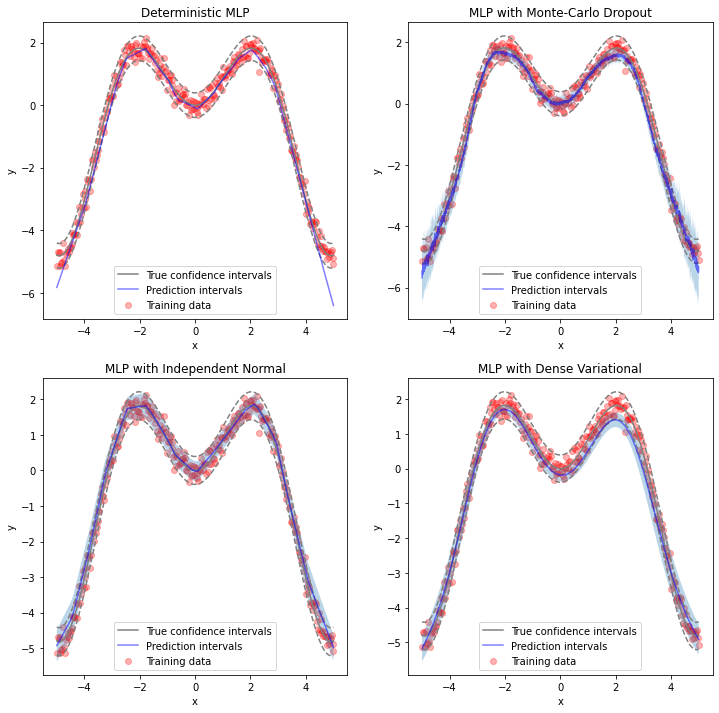

In [27]:
q95 = norm.ppf(0.95)
noise = gauss_function(X_test, *sig_noise)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
coords = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]
y_preds = [
    y_determ_pred,
    y_mcdrop_mean,
    y_aleatoric_mean.numpy(),
    y_epistemic_mean
]
y_lows = [
    y_determ_pred,
    (y_mcdrop_mean - q95*y_mcdrop_sd)[:, 0],
    (y_aleatoric_mean - q95*y_aleatoric_sd).numpy()[:, 0],
    (y_epistemic_mean - q95*y_epistemic_sd)[:, 0]
]
y_ups = [
    y_determ_pred,
    (y_mcdrop_mean + q95*y_mcdrop_sd)[:, 0],
    (y_aleatoric_mean + q95*y_aleatoric_sd).numpy()[:, 0],
    (y_epistemic_mean + q95*y_epistemic_sd)[:, 0]
]
for i, title in enumerate(titles):
    print(i)
    plot_1d_data(
        X_train.ravel(),
        y_train.ravel(), 
        X_test.ravel(),
        y_mesh.ravel(),
        1.96*noise.ravel(), 
        y_preds[i].ravel(),
        y_lows[i].ravel(),
        y_ups[i].ravel(), 
        ax=coords[i],
        title=titles[i]
    )

In [49]:
def plot_x_y(
    x,
    ys,
    xlabel = "x",
    ylabel = "y",
    labels = None,
    title = None,
    ax = None
):
    """
    Plot list of 1d curves.
    """
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for y in ys:
        ax.plot(x, y)
    if title is not None:
        ax.set_title(title)
    if labels is not None:
        ax.legend(labels)


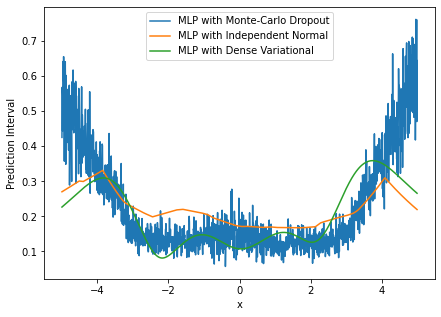

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
plot_x_y(
    x=X_test,
    ys=[y_mcdrop_sd, y_aleatoric_sd, y_epistemic_sd],
    xlabel='x',
    ylabel='Prediction Interval',
    labels=titles[1:],
    ax=axs)

# Fonction polynomiale de degré 3 avec bruit hétéroscédastique

$$ y_i = x_i^3 + \epsilon_i$$
avec $\epsilon_i \sim N(0, \sigma)$ 
et $\sigma = N(1, 1)$

### Génération des données hétéroscédastiques pour 3 tailles de jeu d'entraînement

In [30]:
sig_noise = [0.5, 1, 1]
n_samples = [100, 1000]
X_trains = [] ; y_trains = [] ; X_tests = [] ; y_tests = [] ; y_meshs = []
for n_sample in n_samples:
    X_train, y_train, X_test, y_test, y_mesh = generate_onedimensional_data(
        lambda x: x**3,
        distrib='uniform',
        noise=True,
        min_x=-1,
        max_x=1,
        n_samples=n_sample,
        sig_noise=sig_noise
    )
    X_trains.append(X_train) ; y_trains.append(y_train)
    X_tests.append(X_test) ; y_meshs.append(y_mesh) ; y_tests.append(y_test)

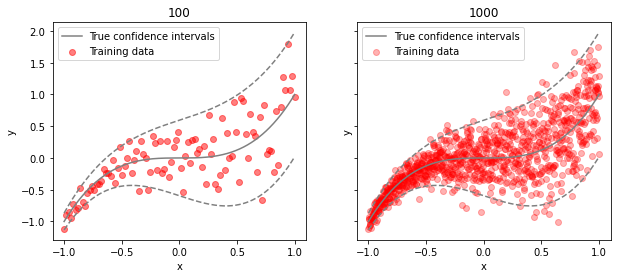

In [31]:
fig, axs = plt.subplots(1, len(n_samples), figsize=(5*len(n_samples), 4), sharex=True, sharey=True)
alphas = [0.5, 0.3, 0.1]
for i, X_train in enumerate(X_trains):
    noise = gauss_function(X_tests[i], *sig_noise)
    plot_1d_data(
        X_train.ravel(),
        y_trains[i].ravel(), 
        X_tests[i].ravel(),
        y_meshs[i].ravel(),
        1.96*noise.ravel(), 
        None,
        None,
        None,
        ax=axs[i],
        title=f"{n_samples[i]}", alpha=alphas[i]
    )

### Modélisation

In [39]:
%%time
mlp_determs = [] ; hist_determs = []
y_determ_preds = []
early_stopping = EarlyStopping(monitor="val_loss", patience=100)
for i, X_train in enumerate(X_trains):
    print(X_trains[i].shape[0])
    mlp_determs.append(get_probabilistic_mlp(
        shape=X_train.shape, 
        hidden_type="dense", 
        output_type="deterministic", 
        hidden_units=[32, 32], 
        activations=["sigmoid", "sigmoid", "sigmoid"], 
        loss="mean_squared_error",
        optimizer=Adam(learning_rate=0.01)
    ))
    hist_determs.append(mlp_determs[-1].fit(
        X_train.reshape(-1, 1), y_trains[i], 
        epochs=1000, 
        batch_size=32,
        callbacks=[early_stopping],
        validation_split=0.1,
        verbose=False
    ))
    y_determ_preds.append(mlp_determs[-1].predict(X_tests[i]))

100
1000
CPU times: user 23 s, sys: 1.38 s, total: 24.4 s
Wall time: 17.3 s


In [40]:
%%time
mlp_aleatorics, hist_aleatorics, y_aleatorics = [], [], []
y_aleatoric_samples, y_aleatoric_means, y_aleatoric_stds = [], [], []
early_stopping = EarlyStopping(monitor="val_loss", patience=100)
for i, X_train in enumerate(X_trains):
    print(X_trains[i].shape[0])
    mlp_aleatorics.append(get_probabilistic_mlp(
        shape=X_trains[i].shape, 
        hidden_type="dense", 
        output_type="probabilistic", 
        hidden_units=[32, 32], 
        activations=["sigmoid", "sigmoid"],
        loss=negative_log_likelihood,
        optimizer=Adam(learning_rate=0.01)
    ))
    hist_aleatorics.append(mlp_aleatorics[-1].fit(
        X_trains[i], y_trains[i], 
        epochs=1000, 
        batch_size=32,
        callbacks=[early_stopping],
        validation_split=0.1,
        verbose=False
    ))
    y_aleatorics.append(mlp_aleatorics[-1](X_tests[i]))
    y_aleatoric_samples.append(y_aleatorics[-1].sample())
    y_aleatoric_means.append(y_aleatorics[-1].mean())
    y_aleatoric_stds.append(y_aleatorics[-1].stddev())

100
1000
CPU times: user 23.2 s, sys: 1.37 s, total: 24.5 s
Wall time: 17.8 s


In [41]:
%%time
mlp_epistemics, hist_epistemics = [], []
y_epistemics, y_epistemic_means, y_epistemic_stds = [], [], []
early_stopping = EarlyStopping(monitor="val_loss", patience=100)
for i, X_train in enumerate(X_trains):
    print(X_trains[i].shape[0])
    mlp_epistemics.append(get_probabilistic_mlp(
        shape=X_trains[i].shape, 
        hidden_type="variationaldense", 
        output_type="deterministic", 
        hidden_units=[32, 32], 
        activations=["sigmoid", "sigmoid"],
        loss="mean_squared_error",
        prior=prior,
        posterior=posterior_mean_field,
        optimizer=Adam(learning_rate=0.01)
    ))
    hist_epistemics.append(mlp_epistemics[-1].fit(
        X_trains[i], y_trains[i], 
        epochs=1000, 
        batch_size=32,
        callbacks=[early_stopping],
        validation_split=0.1,
        verbose=True
    ))
    y_epistemics.append(np.stack([mlp_epistemics[-1](X_tests[i]) for _ in range(n_preds)]))
    y_epistemic_means.append(np.mean(y_epistemics[-1], axis=0))
    y_epistemic_stds.append(np.std(y_epistemics[-1], axis=0))

100
Epoch 1/1000
3/3 [==============================] - 1s 167ms/step - loss: 99.1716 - val_loss: 98.9784
Epoch 2/1000
3/3 [==============================] - 0s 20ms/step - loss: 98.6602 - val_loss: 98.6226
Epoch 3/1000
3/3 [==============================] - 0s 21ms/step - loss: 98.3088 - val_loss: 98.6691
Epoch 4/1000
3/3 [==============================] - 0s 22ms/step - loss: 97.7956 - val_loss: 99.5972
Epoch 5/1000
3/3 [==============================] - 0s 20ms/step - loss: 97.8636 - val_loss: 98.7071
Epoch 6/1000
3/3 [==============================] - 0s 21ms/step - loss: 97.2925 - val_loss: 97.6358
Epoch 7/1000
3/3 [==============================] - 0s 22ms/step - loss: 96.8854 - val_loss: 97.1675
Epoch 8/1000
3/3 [==============================] - 0s 25ms/step - loss: 96.5635 - val_loss: 97.2615
Epoch 9/1000
3/3 [==============================] - 0s 20ms/step - loss: 96.3081 - val_loss: 97.1202
Epoch 10/1000
3/3 [==============================] - 0s 22ms/step - loss: 96.1846 - va

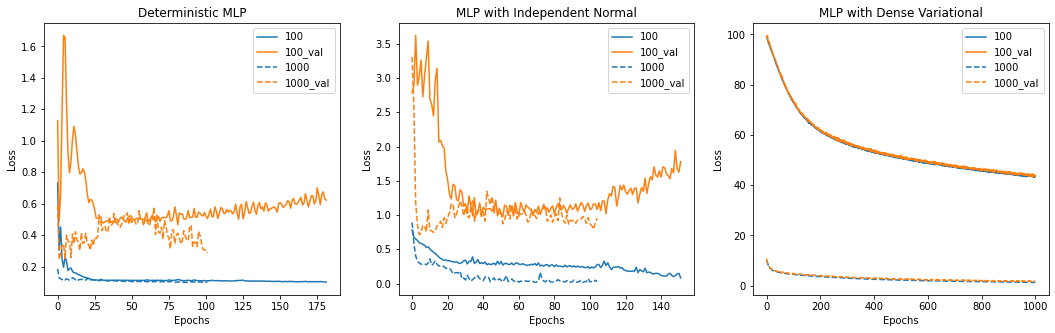

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)
titles = ['Deterministic MLP', 'MLP with Independent Normal', 'MLP with Dense Variational']
list_hists = [hist_determs, hist_aleatorics, hist_epistemics]
for i, hists in enumerate(list_hists):
    plot_loss_history(
        hists,
        plot_val=True,
        title=titles[i],
        ax=axs[i],
        legend=["100", "100_val", "1000", "1000_val"])

### Visualisation des résultats

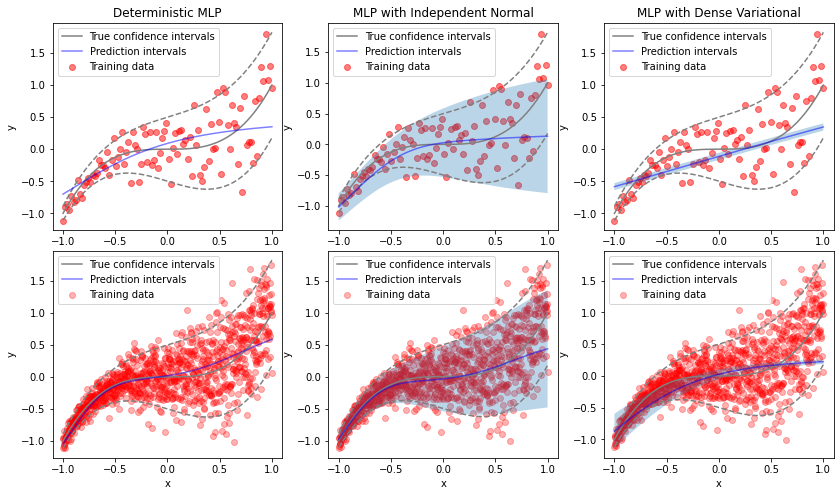

In [43]:
q95 = norm.ppf(0.95)
fig, axs = plt.subplots(len(n_samples), 3, figsize=(7*len(n_samples), 8))
plt.subplots_adjust(wspace=0.2, hspace=0.1)
mlps = [mlp_determs, mlp_aleatorics, mlp_epistemics]
for im, mlp in enumerate(mlps):
    for i, X_train in enumerate(X_trains):
        noise = gauss_function(X_tests[i], *sig_noise)
        if im == 0:
            y_pred = y_determ_preds[i] ; y_low = y_determ_preds[i] ; y_up = y_determ_preds[i]
        elif im == 1:
            y_pred = y_aleatoric_means[i].numpy()[:, 0] 
            y_low = (y_aleatoric_means[i] - q95*y_aleatoric_stds[i]).numpy()[:, 0] 
            y_up = (y_aleatoric_means[i] + q95*y_aleatoric_stds[i]).numpy()[:, 0]
        elif im == 2:
            y_pred = y_epistemic_means[i]
            y_low = (y_epistemic_means[i] - q95*y_epistemic_stds[i])
            y_up = (y_epistemic_means[i] + q95*y_epistemic_stds[i])
        if i == 0:
            title = titles[im]
        else:
            title = None
        plot_1d_data(
            X_trains[i].ravel(),
            y_trains[i].ravel(), 
            X_tests[i].ravel(),
            y_meshs[i].ravel(),
            q95*noise.ravel(), 
            y_pred.ravel(),
            y_low.ravel(),
            y_up.ravel(), 
            ax=axs[i, im],
            title=title,
            alpha=alphas[i]
        )

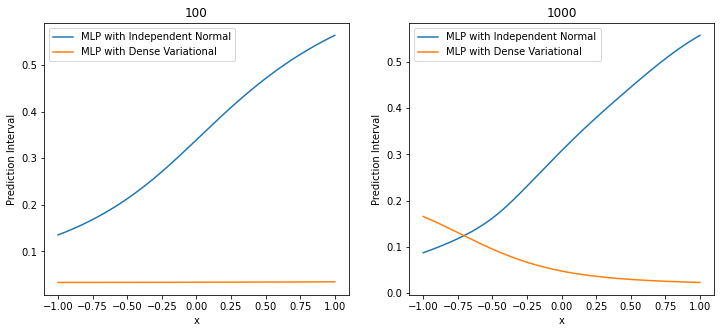

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    plot_x_y(
        x=X_tests[i],
        ys=[y_aleatoric_stds[i], y_epistemic_stds[i]],
        xlabel='x',
        ylabel='Prediction Interval',
        labels=titles[1:],
        title=f"{n_samples[i]}",
        ax=axs[i]
    )